https://www.tensorflow.org/tutorials/images/transfer_learning

https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub


https://github.com/Locchuong96/Machine-Learning/blob/main/TensorFlow2/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb

https://github.com/Locchuong96/Machine-Learning/blob/main/TensorFlow2/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

https://github.com/Locchuong96/Machine-Learning/blob/main/TensorFlow2/07_food_vision_milestone_project_1.ipynb

In [1]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf 

In [3]:
from google.colab import drive 
drive.mount('/content/Drive')

Mounted at /content/Drive


### Data preprocessing

In [6]:
# url_dataset = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',origin  = url_dataset,extract = True)
# path = os.path.join(os.path.dirname(path_to_zip),'/content/cats_and_dogs_filtered')
# train_dir = os.path.join(path,'train')
# validation_dir = os.path.join(path,'validation')
# print(f"path_to_zip: {path_to_zip}")
# print(f"path_to_zip: {path}")
# print(f"train_dir: {train_dir}")
# print(f"validation_dir: {validation_dir}")

--2022-03-11 06:53:30--  http://url_dataset/
Resolving url_dataset (url_dataset)... failed: Name or service not known.
wget: unable to resolve host address ‘url_dataset’


In [7]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-03-11 06:54:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  83.1MB/s    in 0.8s    

2022-03-11 06:54:10 (83.1 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
!unzip /content/cats_and_dogs_filtered.zip

Archive:  /content/cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/

In [45]:
train_dir = '/content/cats_and_dogs_filtered/train'
validation_dir = '/content/cats_and_dogs_filtered/validation'

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle = True,
                                                            batch_size = BATCH_SIZE,
                                                            image_size = IMG_SIZE
                                                            )
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle = True,
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size  = IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [46]:
dir(train_dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_drop_remainder',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_get_legacy_saved_model_children',
 '_graph',
 '_graph

In [47]:
class_names = train_dataset.class_names
print(f'train_dataset: {train_dataset.class_names}')
print(f'validation_dataset: {validation_dataset.class_names}')

train_dataset: ['cats', 'dogs']
validation_dataset: ['cats', 'dogs']


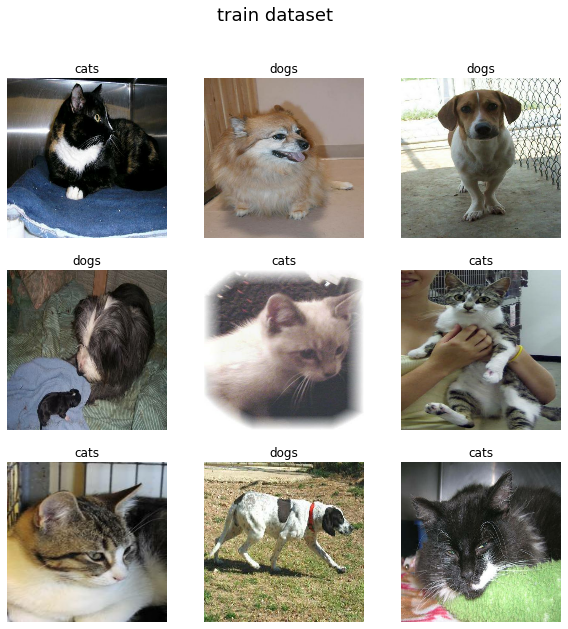

In [48]:
plt.figure(figsize = (10,10))

for images,labels in train_dataset.take(1):
  for i in range(9):
    plt.suptitle('train dataset',fontsize = 18)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [49]:
# create a test set, 20% of validation test
val_batches = tf.data.experimental.cardinality(validation_dataset)
print(f'val_batches: {val_batches}')
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches //5)
print('Number of validation batches: %d' % (tf.data.experimental.cardinality(validation_dataset)))
print('Number of test batches: %d' % (tf.data.experimental.cardinality(test_dataset)))

val_batches: 32
Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

In [50]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

### Use data augmentation

In [51]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomRotation(0.2)
                                        ])

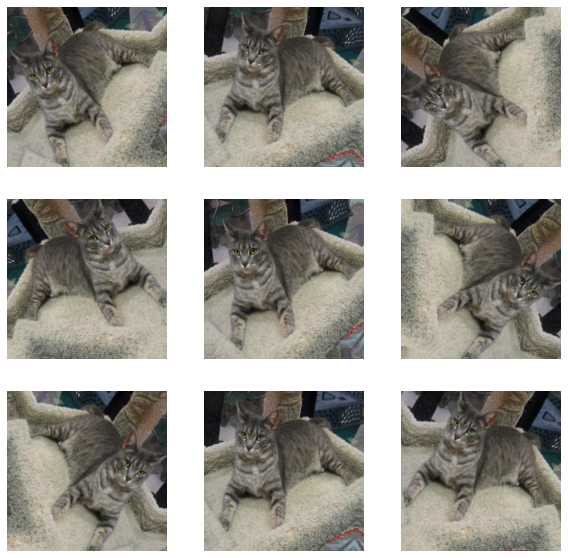

In [55]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize = (10,10))
  first_image =  image[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

### Rescale pixel values
your basemodel is mobileNetv2, this model expects pixel values in `[-1,1]` but at this point,the pixel values in your images are in `[0,255]` to  rescale them, use the preprocessing method included with the model

In [56]:
# rescaling object of mobileNetv2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.applications.mobilenet_v2.preprocess_input>

In [58]:
# of rescale object from keras.layers.Rescaling
rescale  = tf.keras.layers.Rescaling(1/127.5, offset = -1)

### Create the base model from the pre-trained convnets
instantiate a mobileNetv2 model pre-loaded with weights trained on ImageNet By specifying the `include_top = False` argument, you load a network that does not include classification layers at the top

In [69]:
IMG_SHAPE = (160,160,3)

In [70]:
basemodel = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet'
                                              )

9420800/9406464 [==============================] - 0s 0us/step


In [72]:
basemodel.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [77]:
image_batch,label_batch = next(iter(train_dataset)) # create a interator for given object
# print(f'image_batch: {image_batch}')
# print(f'label_batch: {label_batch}')
feature_batch = basemodel(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Text(0.5, 1.0, 'feature extracted from a batch')

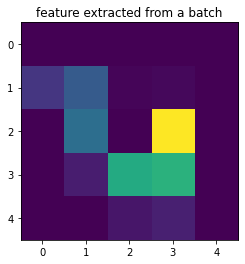

In [97]:
plt.imshow(feature_batch[np.random.randint(feature_batch.shape[0])][:,:,np.random.randint(feature_batch.shape[-1])])
plt.title('feature extracted from a batch')

### Feature extraction
Freeze all layers from base model and and use feature extraction
add a classifier on top of it and train the top-level classifier

In [86]:
# Set entire layer freeze
basemodel.trainable = False
print(f'basemodel: mobileNetv2 layers: {len(basemodel.layers)}')
for layer in basemodel.layers:
  print(f"{layer}: \t {layer.trainable}")

basemodel: mobileNetv2 layers: 154
<keras.engine.input_layer.InputLayer object at 0x7f1b6ace0bd0>: 	 False
<keras.layers.convolutional.Conv2D object at 0x7f1b6d346d50>: 	 False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1b692f2c10>: 	 False
<keras.layers.advanced_activations.ReLU object at 0x7f1b6b678650>: 	 False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f1b6d263fd0>: 	 False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1b6d345690>: 	 False
<keras.layers.advanced_activations.ReLU object at 0x7f1b6d2c8690>: 	 False
<keras.layers.convolutional.Conv2D object at 0x7f1b6d245b10>: 	 False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1b6bb0cad0>: 	 False
<keras.layers.convolutional.Conv2D object at 0x7f1b6bb2f810>: 	 False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1b6bb1fb50>: 	 False
<keras.layers.advanced_activations.ReLU object

### Add a classification head

to generate predictions fromblock of features, average over tje spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 1280 element vector per image

In [99]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [102]:
# Apply Dense layer to convert these features into a single prediction per image, don't need a activation function because 
# this prediction will be treated as a logit or a raw prediction value, positive numbers predict class 1, negative numbers predict class 0
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
print(prediction_batch)

(32, 1)
tf.Tensor(
[[ 0.43938366]
 [ 1.1401491 ]
 [ 0.24760103]
 [-0.24401796]
 [ 0.4826861 ]
 [-0.61944455]
 [-0.27529618]
 [ 0.5839369 ]
 [ 0.7368114 ]
 [ 0.28076494]
 [-1.0465192 ]
 [ 0.38935244]
 [-0.01915872]
 [ 0.5882609 ]
 [ 0.3132882 ]
 [-0.26041135]
 [ 0.26728594]
 [-0.99879813]
 [-0.69651794]
 [-0.38257214]
 [ 1.0488725 ]
 [-0.3062904 ]
 [ 1.4028602 ]
 [-0.27865267]
 [ 0.13401479]
 [-0.1684376 ]
 [ 0.2393229 ]
 [ 0.55867004]
 [ 0.21027303]
 [ 0.20276761]
 [ 0.00182444]
 [-0.06297898]], shape=(32, 1), dtype=float32)


In [106]:
from tensorflow.python.ops.gen_array_ops import invert_permutation
# build a model chaining together the data augmentation, rescaling, basemodel and feature extractor layers using the keras API
# as our model contains a batchNormalization
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = basemodel(x,training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

In [107]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [108]:
for layer in model.layers:
  print(f"{layer}:{layer.trainable}")

<keras.engine.input_layer.InputLayer object at 0x7f1b6a4a62d0>:True
<keras.engine.sequential.Sequential object at 0x7f1b6ac7bfd0>:True
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x7f1b6a4a6190>:True
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x7f1b690f1b90>:True
<keras.engine.functional.Functional object at 0x7f1b6aae6050>:False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1b6aa9eb10>:True
<keras.layers.core.dropout.Dropout object at 0x7f1b6ab1a0d0>:True
<keras.layers.core.dense.Dense object at 0x7f1b6b900f50>:True


### Compile the model

In [109]:
base_learning_rate = 0.0001
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              metrics= ['accuracy']
              )

In [111]:
# Variable
print(len(model.trainable_variables))
tf.Variable

2


tensorflow.python.ops.variables.Variable

### Train model

In [112]:
initial_epochs = 10
loss0,accuracy0 = model.evaluate(validation_dataset,verbose = 1)


26/26 [==============================] - 17s 485ms/step - loss: 0.7881 - accuracy: 0.4938


In [116]:
print("intital loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

intital loss: 0.79
initial accuracy: 0.49


In [117]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset
                    )

Epoch 1/10
63/63 [==============================] - 50s 715ms/step - loss: 0.6992 - accuracy: 0.5885 - val_loss: 0.5364 - val_accuracy: 0.7351
Epoch 2/10
63/63 [==============================] - 51s 809ms/step - loss: 0.5094 - accuracy: 0.7375 - val_loss: 0.3922 - val_accuracy: 0.8441
Epoch 3/10
63/63 [==============================] - 52s 818ms/step - loss: 0.4311 - accuracy: 0.7860 - val_loss: 0.3020 - val_accuracy: 0.8985
Epoch 4/10
63/63 [==============================] - 61s 973ms/step - loss: 0.3545 - accuracy: 0.8465 - val_loss: 0.2392 - val_accuracy: 0.9220
Epoch 5/10
63/63 [==============================] - 49s 763ms/step - loss: 0.3081 - accuracy: 0.8610 - val_loss: 0.2060 - val_accuracy: 0.9332
Epoch 6/10
63/63 [==============================] - 56s 888ms/step - loss: 0.2867 - accuracy: 0.8785 - val_loss: 0.1819 - val_accuracy: 0.9381
Epoch 7/10
63/63 [==============================] - 47s 749ms/step - loss: 0.2573 - accuracy: 0.8920 - val_loss: 0.1540 - val_accuracy: 0.9542

### Learning curves

In [123]:
def plot_learning_curves(history):
  '''
  Plot the learning curves
  Arguments:
  history --- the history object generated from training
  Return:
  seperately accuracy and loss plots of both train and validation dataset
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure(figsize = (10,10))
  # plot accuracy curve
  plt.subplot(2,1,1)
  plt.plot(acc,label = 'accuracy')
  plt.plot(val_acc,label = 'acc_accuracy') 
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1]) # from plt.ylim to 1
  plt.xlabel('Epochs')
  plt.title('accuracy plot') 
  plt.legend()
  # plot loss curve
  plt.subplot(2,1,2)
  plt.plot(loss,label = 'loss')
  plt.plot(val_loss,label = 'acc_loss') 
  plt.ylabel('Loss')
  plt.ylim([0,1.0])
  plt.xlabel('Epochs')
  plt.title('loss plot') 
  plt.legend()

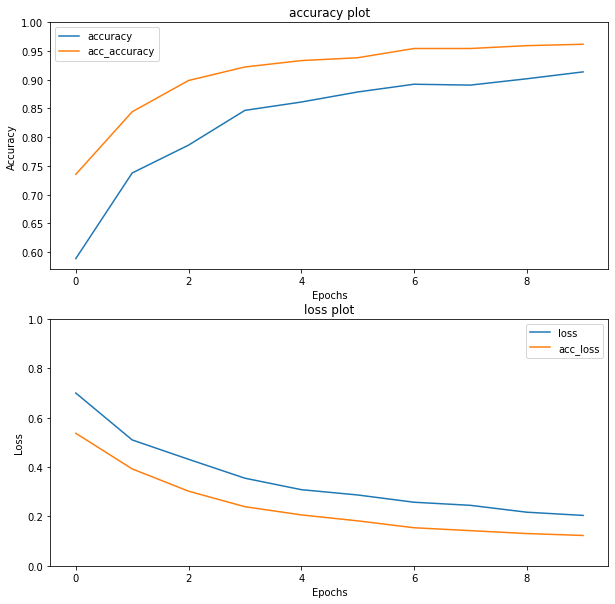

In [124]:
plot_learning_curves(history)

### Un-freeze the top layers of the model

All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable, Then you should recompile the model (necessary for these changes to take effect),and resume training

In [125]:
basemodel.trainable = True

In [127]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ",len(basemodel.layers))
# Fine-tune from this layer onewards
fine_tune_at = 100
# Freeze all the layers before the 'fine_tune_at' layer
for layer in basemodel.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model again

In [132]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = ['accuracy']
              )

In [133]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [134]:
len(model.trainable_variables)

56

In [136]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs  # start training at feature extraction
print(history.epoch[-1])

9


In [137]:
history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1], # epoch at which is start training
                         validation_data = validation_dataset
                         )

Epoch 10/20
63/63 [==============================] - 81s 1s/step - loss: 0.1470 - accuracy: 0.9365 - val_loss: 0.0551 - val_accuracy: 0.9752
Epoch 11/20
63/63 [==============================] - 72s 1s/step - loss: 0.1311 - accuracy: 0.9425 - val_loss: 0.0514 - val_accuracy: 0.9728
Epoch 12/20
63/63 [==============================] - 77s 1s/step - loss: 0.1089 - accuracy: 0.9580 - val_loss: 0.0427 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 75s 1s/step - loss: 0.0840 - accuracy: 0.9650 - val_loss: 0.0495 - val_accuracy: 0.9765
Epoch 14/20
63/63 [==============================] - 71s 1s/step - loss: 0.1026 - accuracy: 0.9610 - val_loss: 0.0420 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 76s 1s/step - loss: 0.0771 - accuracy: 0.9720 - val_loss: 0.0334 - val_accuracy: 0.9901
Epoch 16/20
63/63 [==============================] - 85s 1s/step - loss: 0.0803 - accuracy: 0.9695 - val_loss: 0.0330 - val_accuracy: 0.9864
Epoch 17/20
6

In [138]:
# Evaluate model
loss1,accuracy1 = model.evaluate(validation_dataset,verbose = 1)

26/26 [==============================] - 14s 515ms/step - loss: 0.0331 - accuracy: 0.9839


The validation loss is much higher than the training loss, so you may get some overfitting

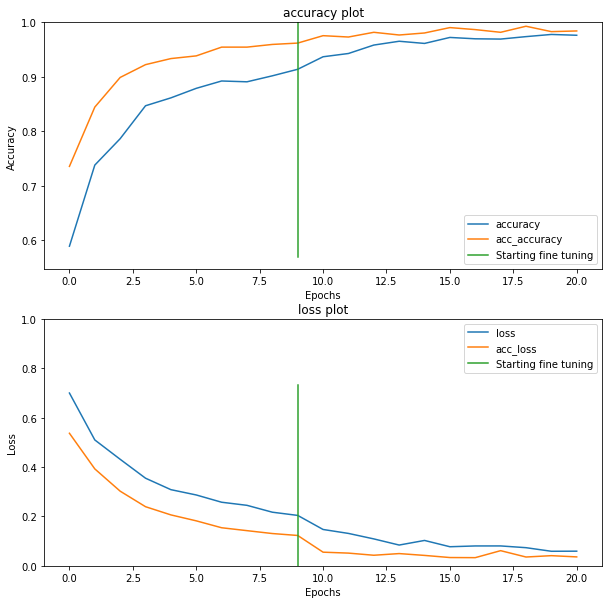

In [141]:
# Get the accuracy and loss from the feature extraction step 
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']
# Get the accuracy and loss from the fine tuning step
acc_2 = history_fine.history['accuracy']
val_acc_2 = history_fine.history['val_accuracy']
loss_2 = history_fine.history['loss']
val_loss_2 = history_fine.history['val_loss']
# sum 2 of them
acc = acc_1 + acc_2
val_acc = val_acc_1 + val_acc_2
loss = loss_1 + loss_2 
val_loss = val_loss_1 + val_loss_2
# plot them
plt.figure(figsize = (10,10))
# plot accuracy curve
plt.subplot(2,1,1)
plt.plot(acc,label = 'accuracy')
plt.plot(val_acc,label = 'acc_accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(),label = 'Starting fine tuning') 
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1]) # from plt.ylim to 1
plt.xlabel('Epochs')
plt.title('accuracy plot') 
plt.legend()
# plot loss curve
plt.subplot(2,1,2)
plt.plot(loss,label = 'loss')
plt.plot(val_loss,label = 'acc_loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(),label = 'Starting fine tuning') 
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.xlabel('Epochs')
plt.title('loss plot') 
plt.legend()

### Predict form the test dataset

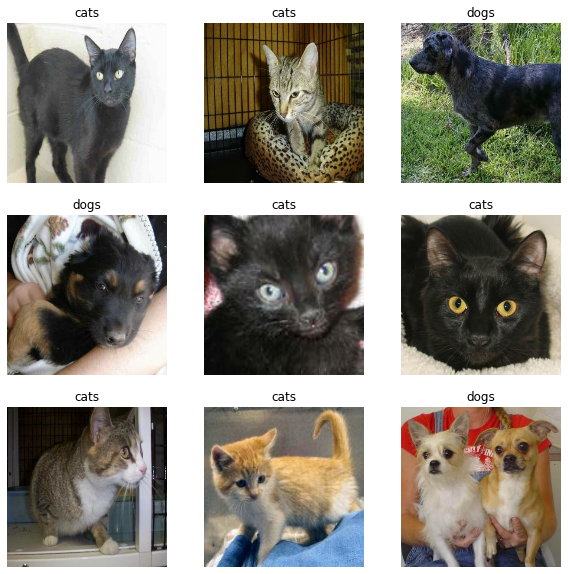

In [144]:
# Retrieve a a batchs of images from the test set
image_batch,label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid activation function since our model return logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5,0,1)
# Plot the prediction
plt.figure(figsize = (10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(class_names[predictions[i]])
  plt.axis('off')

Summary
  - **Using a pre-trained model for feature extraction**: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

  - **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.